In [17]:
import os
import sys
import random
import numpy as np
import torch
import h5py
import cv2
from PIL import Image
from torch.autograd import Variable
import matplotlib.pyplot as plt
#from script_training import weights_init_kaiming
from model import *
from running_func import *
from utils import *
test_whole_Image = './test_8.txt'
class Args():
    def __init__(self, nChannel,nDenselayer,nFeat,growthRate):
        self.nChannel = nChannel
        self.nDenselayer = nDenselayer
        self.nFeat = nFeat
        self.growthRate = growthRate
        self.use_cuda = True
        self.result_dir = './result/'
args = Args(6,3,64,32)
torch.manual_seed(1)
if 1 and torch.cuda.is_available():
    torch.cuda.manual_seed(1)

#load data
testimage_dataset = torch.utils.data.DataLoader(
    testimage_dataloader(test_whole_Image),
    batch_size=1)

def weights_init_kaiming(m):
    classname = m.__class__.__name__
    if classname.find('Conv2d') != -1:
        init.kaiming_normal_(m.weight.data)

##



In [68]:
model = AHDR(args)
model.apply(weights_init_kaiming)
model.cuda()
model.eval()
start_step = 0
trained_model_dir = './trained-model/'
trained_model_filename = '2layer/trained_model800.pkl'
model = model_load(model, trained_model_dir, trained_model_filename)
class SaveOutput:
    def __init__(self):
        self.outputs = []
    def __call__(self, module, module_in):
        self.outputs.append(module_in)
    def clear(self):
        self.outputs = []  
        
######### Save inputs from selected layer ##########
with torch.no_grad():
    save_output = SaveOutput()
    count = 0
    for layer in model.modules():
        if isinstance(layer, torch.nn.Conv2d):
            #print("prehooked"
            #layer.register_forward_pre_hook(save_output)       ## Input for the module will be grapped       
            #print(save_output.outputs)
            pass
        count+= 1
    print('Layer',count)
model.WRM.conv2.register_forward_pre_hook(save_output)
model.WRM.DWT.register_forward_pre_hook(save_output)

Layer 47


In [69]:
print(model.WRM)

SRCNN(
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU(inplace=True)
  (DWT): DWT()
  (IDWT): IWT()
)


In [70]:

start = time.time()
#loss = testing_fun(model, testimage_dataset, args)
test_loaders = testimage_dataset
model.eval()
test_loss = 0
num = 0
with torch.no_grad():
    for data, target in test_loaders:
        #print('2'*50,data.shape,sys.getsizeof(data))
        Test_Data_name = test_loaders.dataset.list_txt[num].split('.h5')[0].split('/')[-1]
        if args.use_cuda:
            data, target = data.cuda(), target.cuda()
        data1 = torch.cat((data[:, 0:3, :], data[:, 9:12, :]), dim=1)
        data2 = torch.cat((data[:, 3:6, :], data[:, 12:15, :]), dim=1)
        data3 = torch.cat((data[:, 6:9, :], data[:, 15:18, :]), dim=1)
        with torch.no_grad():
            data1 = Variable(data1)
            data2 = Variable(data2)
            data3 = Variable(data3)
            target = Variable(target)
        H,W = data1.shape[-2:]
        h,w = 750,500
        #print('3'*30,data1.shape,target.shape,H,W)
        tot_pix = h*w
        rate = int(np.ceil((H*W/tot_pix)**0.5))
        out = torch.zeros_like(target)
        for i in range(rate):
            for j in range(rate):
                data1_crop = data1[:,:,h*i:h*(i+1),w*j:w*(j+1)]
                data2_crop = data2[:,:,h*i:h*(i+1),w*j:w*(j+1)]
                data3_crop = data3[:,:,h*i:h*(i+1),w*j:w*(j+1)]
                #print('H'*50,data1_crop.shape)
                output = model(data1_crop, data2_crop, data3_crop)
end = time.time()
print('Running Time: {} seconds'.format(end - start))

Running Time: 0.977104902267456 seconds


In [71]:
print("1st convolution's input size:", save_output.outputs[0][0].shape)
print("2st convolution's input size:", save_output.outputs[1][0].shape)

1st convolution's input size: torch.Size([1, 64, 750, 500])
2st convolution's input size: torch.Size([4, 64, 375, 250])


## Plot input of Conv before discrete wavelet transform

8
torch.Size([1000, 1500])


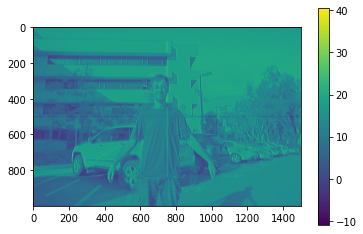

In [72]:
with torch.no_grad():
    print(len(save_output.outputs))
    h,w = 750,500
    tot_pix = h*w
    rate = int(np.ceil((H*W/tot_pix)**0.5))
    out = torch.zeros((64,750*2,500*2))
    #Output = save_output.outputs[1][0][0,:]
    #Output = torch.sum(Output,axis=0).cpu().permute((1,0))
    Ind = 0
    mul = 2
    out[:,:h,:w] = save_output.outputs[Ind+mul*0][0]
    out[:,:h,w:] = save_output.outputs[Ind+mul*1][0]
    out[:,h:,:w] = save_output.outputs[Ind+mul*2][0]
    out[:,h:,w:] = save_output.outputs[Ind+mul*3][0]
    out = torch.sum(out,axis=0).cpu().permute((1,0))
    print(out.shape)
    plt.imshow(out)
    plt.colorbar()
    plt.show()

8
torch.Size([64, 750, 500]) torch.Size([64, 375, 250])
torch.Size([500, 750])


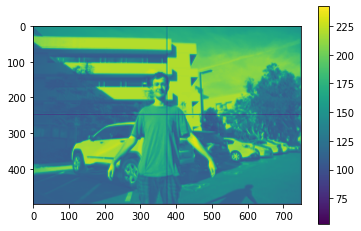

In [78]:
print(len(save_output.outputs))
h,w = int(750/2),int(500/2)
tot_pix = h*w
rate = int(np.ceil((H*W/tot_pix)**0.5))
out = torch.zeros((64,h*2,w*2))
#Output = save_output.outputs[1][0][0,:]
#Output = torch.sum(Output,axis=0).cpu().permute((1,0))
Ind = 1
mul = 1
chan = 0
print(out.shape,save_output.outputs[Ind+mul*0][0][0].shape)
out[:,:h,:w] = save_output.outputs[Ind+mul*0][0][chan]
out[:,:h,w:] = save_output.outputs[Ind+mul*1][0][chan]
out[:,h:,:w] = save_output.outputs[Ind+mul*2][0][chan]
out[:,h:,w:] = save_output.outputs[Ind+mul*3][0][chan]
out = torch.sum(out,axis=0).cpu().permute((1,0))
print(out.shape)
plt.imshow(out)
plt.colorbar()
plt.show()